In [1]:
import diffxpy.api as de
import loompy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy_groupies as npg
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist
import seaborn
import matplotlib as mpl
import gget

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

# colors for ROI Groups
color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

2022-10-10 18:45:04.364034: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/lib:/usr/local/lib64:/usr/lib64
2022-10-10 18:45:04.364063: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
cbl = seaborn.color_palette('colorblind')
cbl

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [3]:
def go_plot(table, n_top=25, filename=None):
    
    top = table.sort_values('adj_p_val')[:n_top][::-1]
    
    plt.figure(None, (1, 3))
    
    ax = plt.subplot(122)
    plt.barh(range(n_top), top['adj_p_val'].to_numpy(), color='grey', alpha=0.3)
    plt.vlines(0.05, -0.5, n_top-0.5, linestyles='dashed', colors=cbl[2])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks([])
    plt.xticks(np.round(np.linspace(0, top['adj_p_val'].max(), 4), 2), rotation=90, fontsize=7)
    plt.margins(y=0.01)
    
    ax = plt.subplot(121)
    n_genes = top['overlapping_genes'].str.len().to_numpy()
    plt.barh(range(n_top), -n_genes, alpha=0.3, color='grey')
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks(range(n_top), top['path_name'].str.split('(').str[0].str.strip(), fontsize=9)
    plt.xticks(
        -np.linspace(0, n_genes.max(), 4),
        np.round(np.linspace(0, n_genes.max(), 4), 2),
        rotation=90,
        fontsize=7
    )
    plt.margins(y=0.01)
    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()

# Oligos

In [4]:
with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_A.agg.loom', 'r') as ds:

    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_A.loom', 'r') as ds:

    labels = clades[ds.ca.Clusters].flatten()
    
    selected_cells = []
    for c in np.unique(labels):
        ix = np.where(labels == c)[0]
        ix = np.random.choice(ix, 25000, replace=False)
        selected_cells.append(ix)
    selected_cells = np.sort(np.hstack(selected_cells))
    
    # get data
    totals = ds.ca.TotalUMI[selected_cells]
    X = ds[:, selected_cells] / totals * np.median(totals)
    labels = labels[selected_cells] 

np.unique(labels)

array([0, 1])

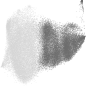

In [6]:
plt.figure(None, (1.5, 1.5))

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_A.loom', 'r') as ds:

    colors = np.array(['dimgray' if l == 0 else 'lightgray' for l in labels])
    
    plt.scatter(ds.ca.TSNE[selected_cells, 0], ds.ca.TSNE[selected_cells, 1], c=colors, s=0.3, lw=0, alpha=0.5, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.tight_layout()

In [7]:
%%time

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_A.loom', 'r') as ds:
    
    results = de.test.pairwise(
        data=X.T,
        grouping=labels,
        test='rank',
        lazy=False,
        gene_names=ds.ra.Gene,
        noise_model=None,
        sample_description=ds.ca.CellID[selected_cells],
        is_logged=False,
        pval_correction='by_test'
    )


INFO:diffxpy:additional kwargs: {'is_logged': False}


Sat Jul 16 13:37:28 2022 INFO additional kwargs: {'is_logged': False}


CPU times: user 14min 31s, sys: 49.7 s, total: 15min 21s
Wall time: 15min 21s


In [5]:
de_table = pd.read_csv('de_oligo.csv').query('qval < 1e-5')
de_table.head()

,Unnamed: 0,gene,pval,qval,log2fc,mean
0,0,SLC27A6,0.000000e+00,0.000000e+00,-2.540213,0.063500
1,1,LINC02823,2.720068e-86,2.457672e-85,-5.620685,0.005921
2,2,PDE4B-AS1,1.873371e-31,7.772124e-31,0.018891,0.048131
3,3,MDFIC2,1.063213e-79,8.789444e-79,-1.086858,0.035417
4,4,AL591115.1,1.282581e-190,3.069656e-189,-2.785818,0.115009


<AxesSubplot:>

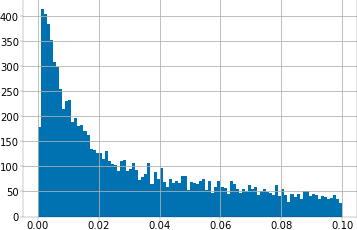

In [6]:
de_table['mean'].hist(bins=100, range=(0, 0.1))

In [7]:
de_table = pd.read_csv('de_oligo.csv').query('qval < 1e-5 & mean > 0.02')
de_table.head()

,Unnamed: 0,gene,pval,qval,log2fc,mean
0,0,SLC27A6,0.000000e+00,0.000000e+00,-2.540213,0.063500
2,2,PDE4B-AS1,1.873371e-31,7.772124e-31,0.018891,0.048131
3,3,MDFIC2,1.063213e-79,8.789444e-79,-1.086858,0.035417
4,4,AL591115.1,1.282581e-190,3.069656e-189,-2.785818,0.115009
6,6,AL118556.2,1.475800e-63,9.927775e-63,-0.393299,0.040170


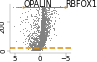

In [8]:
plt.figure(None, (1.1, 0.9))
ax = plt.subplot(111)

x = de_table['log2fc']
y = np.copy(de_table['qval'])
# setting to less than 1e-300 makes np.log10 inf
y[y == 0] = 1e-300
y = -np.log10(y)
ax.scatter(x, y, s=1, lw=0, color='grey', rasterized=True)
ax.hlines(-np.log10(1e-20), -6, 6, linestyles='dashed', color=cbl[1])
for g in ['RBFOX1', 'OPALIN']:
    ix = de_table['gene'] == g
    ax.scatter(x[ix], y[ix], s=5, lw=0, color=cbl[1])
    ax.text(x[ix], y[ix], g, fontsize=8)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlim(-6, 6)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7, rotation=90)
ax.invert_xaxis()
plt.savefig('/home/kimberly/figures/figure5/volcano_oligo.pdf', dpi=300)

# OPCs

In [27]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.agg.loom', 'r') as ds:

    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

    labels = clades[ds.ca.Clusters].flatten()
    
    selected_cells = []
    for c in np.unique(labels):
        ix = np.where(labels == c)[0]
        ix = np.random.choice(ix, 25000, replace=False)
        selected_cells.append(ix)
    selected_cells = np.sort(np.hstack(selected_cells))
    
    # get data
    totals = ds.ca.TotalUMI[selected_cells]
    X = ds[:, selected_cells] / totals * np.median(totals)
    labels = labels[selected_cells] 

np.unique(labels)

array([0, 1])

In [28]:
%%time

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:
    
    results = de.test.pairwise(
        data=X.T,
        grouping=labels,
        test='rank',
        lazy=False,
        gene_names=ds.ra.Gene,
        noise_model=None,
        sample_description=ds.ca.CellID[selected_cells],
        is_logged=False,
        pval_correction='by_test'
    )


INFO:diffxpy:additional kwargs: {'is_logged': False}


Fri Jul 15 20:52:28 2022 INFO additional kwargs: {'is_logged': False}


CPU times: user 15min 13s, sys: 51.1 s, total: 16min 5s
Wall time: 16min 4s


In [9]:
de_table = pd.read_csv('de_opc.csv').query('qval < 1e-5')
de_table.head()

,Unnamed: 0,gene,pval,qval,log2fc,mean
0,0,HES5,0.000000e+00,0.000000e+00,-2.962547,0.333586
1,1,GPC5,0.000000e+00,0.000000e+00,-3.448639,2.135822
2,2,ZNF736P9Y,1.943288e-299,3.174928e-297,-7.386404,0.033742
3,3,APOE,0.000000e+00,0.000000e+00,-1.752303,0.206426
4,4,LRRC3B,0.000000e+00,0.000000e+00,-3.404837,0.206313


<AxesSubplot:>

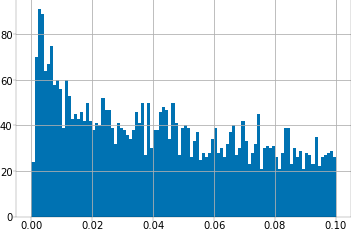

In [11]:
de_table['mean'].hist(bins=100, range=(0, 0.1))

In [12]:
de_table = pd.read_csv('de_opc.csv').query('qval < 1e-5 & mean > 0.02')

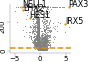

In [81]:
plt.figure(None, (1.1, 0.9))
ax = plt.subplot(111)

x = de_table['log2fc']
y = np.copy(de_table['qval'])
# setting to less than 1e-300 makes np.log10 inf
y[y == 0] = 1e-300
y = -np.log10(y)
plt.scatter(x, y, s=1, lw=0, color='grey', rasterized=True)
plt.hlines(-np.log10(1e-20), -6, 6, linestyles='dashed', color=cbl[1])
for g in ['HES1', 'IRX5', 'LHX2', 'NELL1', 'PAX3']:
    ix = de_table['gene'] == g
    plt.scatter(x[ix], y[ix], s=5, lw=0, color=cbl[1])
    plt.text(x[ix], y[ix], g, fontsize=8)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlim(-6, 6)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7, rotation=90)
plt.savefig('/home/kimberly/figures/figure5/volcano_opcs.pdf', dpi=300)

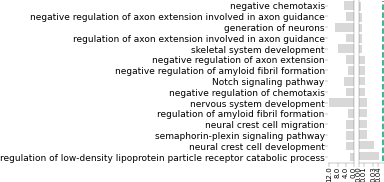

In [146]:
de_genes = de_table.query('log2fc < -1.58 | log2fc > 1.58')['gene'].to_list()
enr_table = gget.enrichr(de_genes, database="ontology")
go_plot(enr_table, 15, '/home/kimberly/figures/figure5/opc_type_GO.pdf')

In [148]:
len(de_genes)

155

In [149]:
enr_table.query('adj_p_val <= 0.05').sort_values('rank')

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,negative chemotaxis (GO:0050919),0.000005,23.591667,286.946959,"[SEMA3D, SEMA3A, SEMA6D, SLIT1, SEMA3E]",0.005752,GO_Biological_Process_2021
1,2,negative regulation of axon extension involved...,0.000015,32.829470,364.082383,"[SEMA3D, SEMA6D, SEMA3A, SEMA3E]",0.007214,GO_Biological_Process_2021
2,3,generation of neurons (GO:0048699),0.000029,6.276812,65.612308,"[IRX1, IRX2, IRX5, LHX2, SEMA3A, CCK, HES1, FG...",0.007214,GO_Biological_Process_2021
3,4,regulation of axon extension involved in axon ...,0.000033,26.258278,271.218891,"[SEMA3D, SEMA6D, SEMA3A, SEMA3E]",0.007214,GO_Biological_Process_2021
4,5,skeletal system development (GO:0001501),0.000033,7.145578,73.793791,"[NCAN, TNFRSF11B, PRELP, HOXD3, BMPR1B, PAPSS2...",0.007214,GO_Biological_Process_2021
5,6,negative regulation of axon extension (GO:0030...,0.000093,19.443709,180.544845,"[SEMA3D, SEMA3A, SEMA6D, SEMA3E]",0.012902,GO_Biological_Process_2021
6,7,negative regulation of amyloid fibril formatio...,0.000095,43.500000,402.692325,"[APOE, CRYAB, LDLR]",0.012902,GO_Biological_Process_2021
7,8,Notch signaling pathway (GO:0007219),0.000102,11.993939,110.288596,"[NRARP, HES1, MAML3, HOXD3, HES5]",0.012902,GO_Biological_Process_2021
8,9,negative regulation of chemotaxis (GO:0050922),0.000105,18.748344,171.697457,"[SEMA3D, SEMA3A, SEMA6D, SEMA3E]",0.012902,GO_Biological_Process_2021
9,10,semaphorin-plexin signaling pathway (GO:0071526),0.000151,16.931425,149.002152,"[SEMA3D, SEMA3A, SEMA6D, SEMA3E]",0.016535,GO_Biological_Process_2021


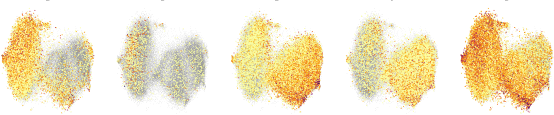

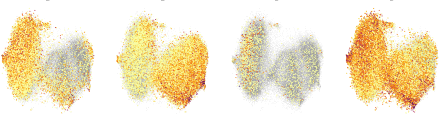

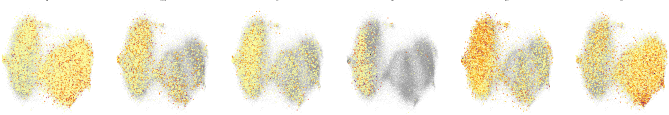

In [ ]:
for n in [0, 3, 4, 5, 7]:

    with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

        plt.figure(None, (12, 2))
        gs = plt.GridSpec(1, 6)

        to_plot = enr_table.loc[n, 'overlapping_genes'][:6]

        for i, g in enumerate(to_plot):
            plt.subplot(gs[i])
            exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
            cells = exp > 0

            plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
            plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True, cmap='inferno_r')

            plt.title(g, fontsize=0.5)
            plt.axis('off')
            plt.margins(0.02, 0.02)
        
        plt.savefig(f'/home/kimberly/figures/figure5/opc_overlapping_genes_{n}.pdf', dpi=300)